In [1]:
import torch
import matplotlib.pyplot as plt
from src.model import VAE
import os
from src.utils import calculate_statistics, visualize_reconstruction, denormalize, interpolate_tiles
from src.data_processing import BrainTileDataset, DensityBasedSampler
import torch
from torch.utils.data import DataLoader

In [2]:
data_path = 'cell_data.h5'
test_set = 'B05' # Change this to the test set you want to evaluate
sampling = 'random' # Change this to sampling method you want to use
global_stats = calculate_statistics(data_path, test_set=test_set)
global_mean = global_stats['mean']
global_std = global_stats['std']

Loading cached statistics for test set B05...


In [3]:
# Find the best model path dynamically
checkpoint_dir = os.path.join(os.getcwd(), 'checkpoints')
if test_set is None:
    best_model_path = [f for f in os.listdir(checkpoint_dir) if sampling in f][0]
    best_model_path = os.path.join(checkpoint_dir, best_model_path)
    test_set = best_model_path.split('-')[-3]
    img_size = int(best_model_path.split('-')[-2])
    assert sampling == best_model_path.split('-')[-1].split('.')[0]
else:
    best_model_path = [f for f in os.listdir(checkpoint_dir) if test_set in f and sampling in f][0]
    best_model_path = os.path.join(checkpoint_dir, best_model_path)
    img_size = int(best_model_path.split('-')[-2])
    assert sampling == best_model_path.split('-')[-1].split('.')[0]

In [4]:
# Load the best checkpoint and initialize the model with saved weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(best_model_path, map_location=device)
model = VAE(img_size=img_size)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
# model = VAE.load_from_checkpoint(best_model_path, map_location=device)
model.eval()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_100\973776068.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


VAE(
  (encoder): Encoder(
    (bottleneck): Sequential(
      (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(

**(a) Latent Space Sampling and Decoding**

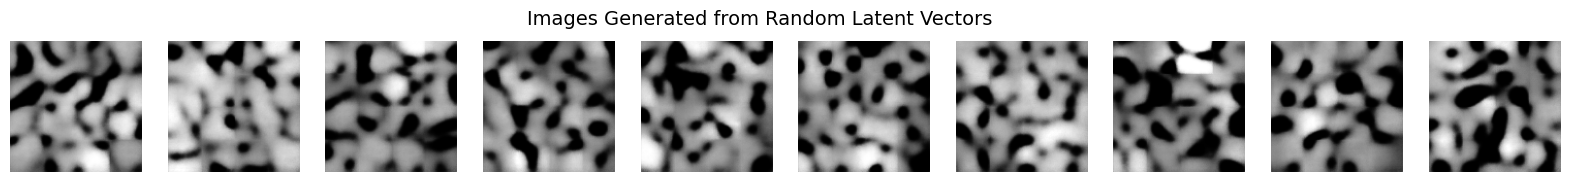

In [40]:
# Sample 10 random latent vectors from a standard Gaussian distribution
latent_vectors = torch.randn(10, model.latent_dim).to(model.device)

# Decode the latent vectors to generate images
with torch.no_grad():
    generated_images = model.decoder(latent_vectors)

# Visualize the generated images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(denormalize(generated_images[i].permute(1, 2, 0).cpu().numpy(), global_mean, global_std), cmap='gray')
    ax.axis('off')
plt.suptitle("Images Generated from Random Latent Vectors", fontsize=14)
plt.show()

**Generation**:
     The VAE learned a compact representation of brain images, which can result in the generation of new a bit plausible samples but not too realistic.

**(b) Interpolation in Latent Space**

In [ ]:
test_dataset = BrainTileDataset(data_path, global_stats, test_set=test_set, tile_size=img_size, testing=True, metadata=True)
sampler = DensityBasedSampler(test_dataset, samples_per_epoch=1024, density=True)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=64,
    sampler=sampler,
    shuffle=False,
)

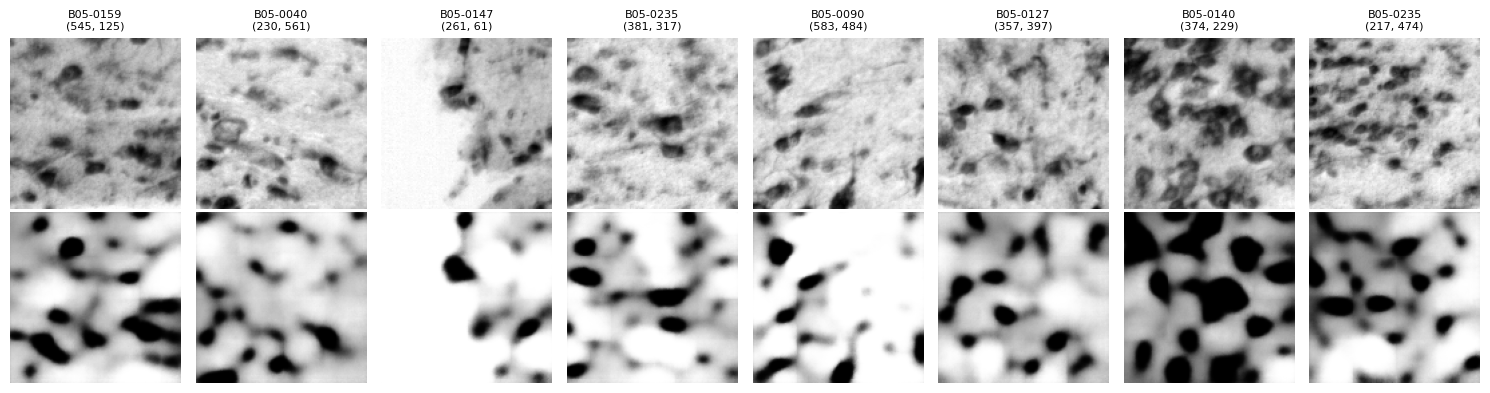

In [7]:
sample_batch, metadata = next(iter(test_dataloader))
sample_batch = sample_batch.to(model.device)
reconstructed, _, _ = model(sample_batch)
reconstructed_denormalized = denormalize(reconstructed.cpu(), global_mean, global_std)
visualize_reconstruction(sample_batch.cpu(), reconstructed_denormalized, metadata)
plt.show()

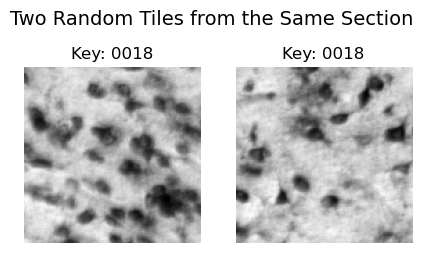

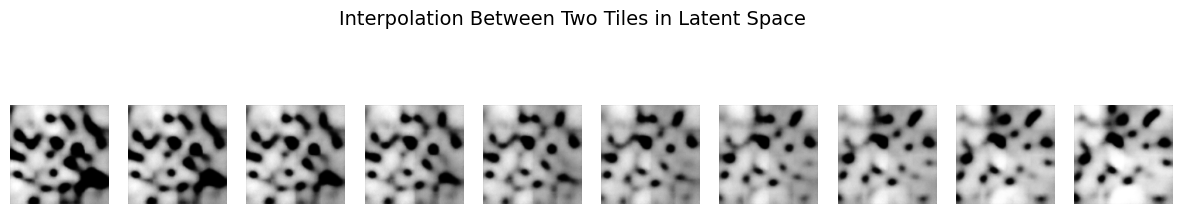

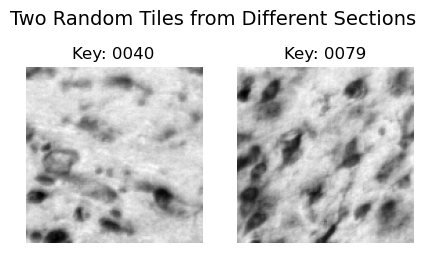

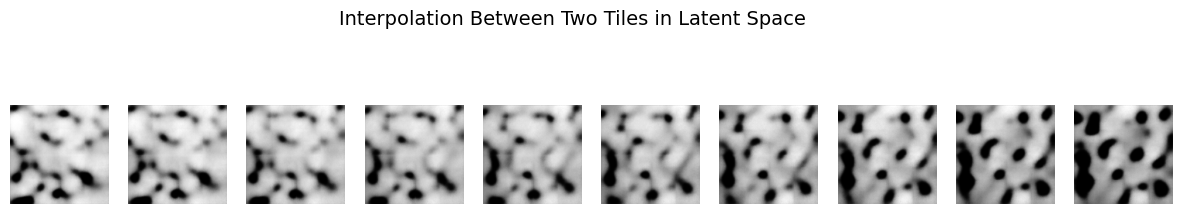

In [8]:
# Interpolate between two random samples
interpolate_tiles(model, sample_batch, metadata, global_mean, global_std, same_section=True)
interpolate_tiles(model, sample_batch, metadata, global_mean, global_std, same_section=False)

**Latent Space Interpolation**:
     The VAE learns a compact and continuous latent space representation of the brain structures. This allows for smooth interpolation between different brain images, which can result in the generation of intermediate structures that are plausible but not too realistic.
    
**Random Sampling**:
     Overestimates cell regions, producing darker and larger black areas that do not align well with the realistic structures of brain cells. This suggests the model generalizes less accurately, likely due to uniform sampling without emphasizing key features.

**(c) Latent Space Visualization**

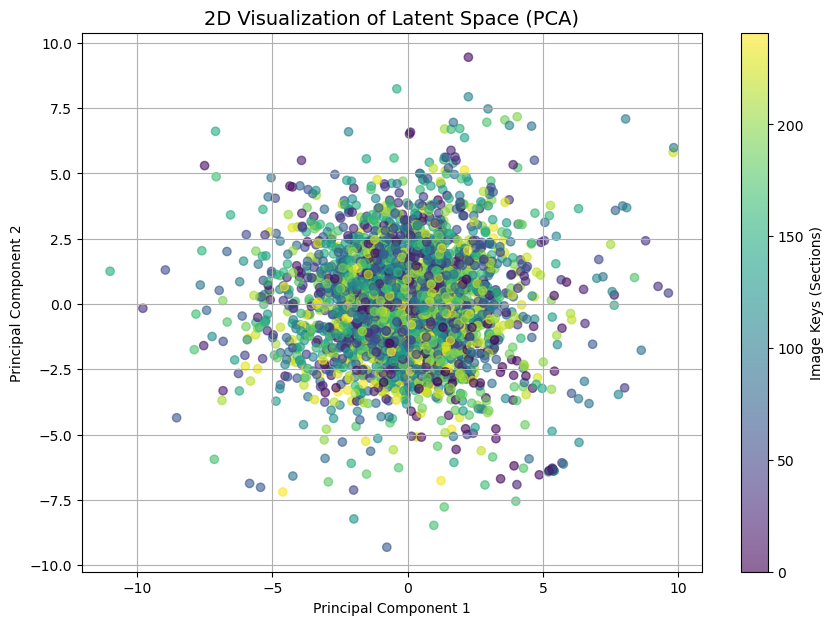

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Sample 3000 tiles from the test dataset
num_tiles = 3000
sample_tiles = []
image_keys = []

while len(sample_tiles) < num_tiles:
    batch, metadata = next(iter(test_dataloader))
    sample_tiles.append(batch)
    image_keys.extend(metadata[1])
    if len(sample_tiles) * batch.size(0) >= num_tiles:
        break

sample_tiles = torch.cat(sample_tiles)[:num_tiles].to(model.device)
image_keys = image_keys[:num_tiles]

# Encode tiles into latent representations
latent_representations, _ = model.encoder(sample_tiles)

# Convert image_keys to numerical labels
label_encoder = LabelEncoder()
image_keys_numeric = label_encoder.fit_transform(image_keys)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
reduced_latents = pca.fit_transform(latent_representations.detach().cpu().numpy())

# Plot the 2D latent space with image_keys as labels
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=image_keys_numeric, alpha=0.6, cmap='viridis')
plt.title("2D Visualization of Latent Space (PCA)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Image Keys (Sections)')
plt.grid(True)

# Annotate each point with its label
# for i, key in enumerate(image_keys):
#     plt.text(reduced_latents[i, 0], reduced_latents[i, 1], key, fontsize=8, ha='right')

plt.show()

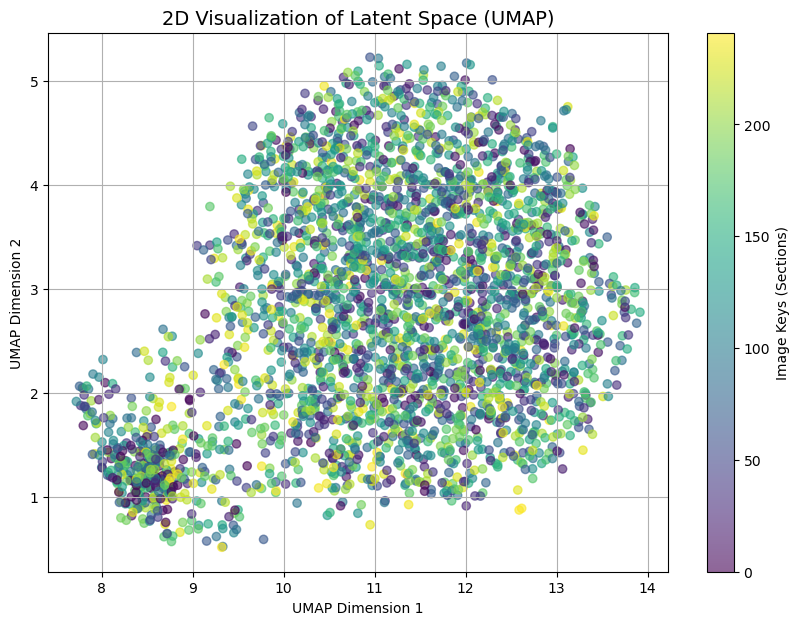

In [10]:
import umap

# Reduce dimensionality using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
reduced_latents_umap = reducer.fit_transform(latent_representations.detach().cpu().numpy())

# Convert image_keys to numerical labels if not already done
if not isinstance(image_keys[0], int):
    image_keys_numeric = label_encoder.fit_transform(image_keys)

# Plot the 2D latent space
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x=reduced_latents_umap[:, 0], y=reduced_latents_umap[:, 1], c=image_keys_numeric, alpha=0.6, cmap='viridis')
plt.title("2D Visualization of Latent Space (UMAP)", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(scatter, label='Image Keys (Sections)')
plt.grid(True)
plt.show()

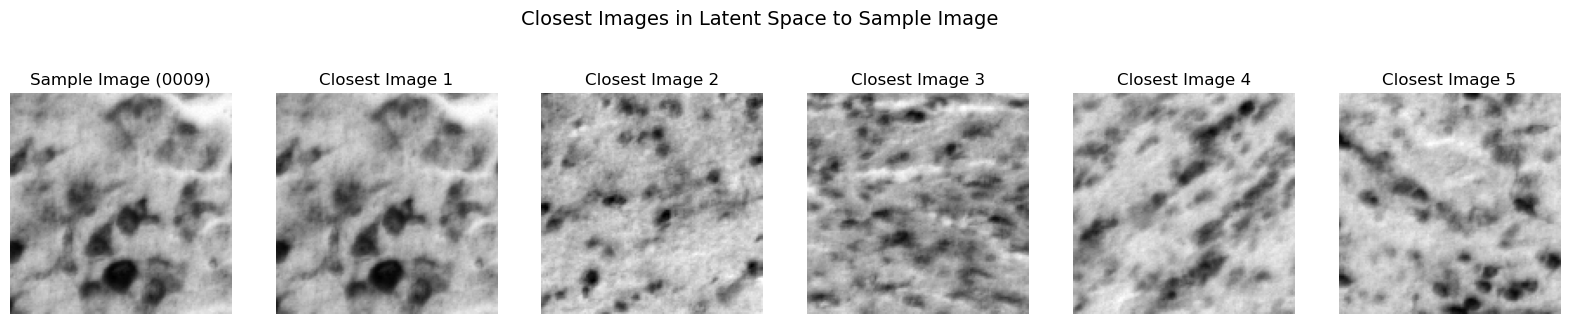

In [11]:
# extract a sample then find the closest 5 samples to it in the latent space and visualize them
sample_idx = 0
sample_tile = sample_tiles[sample_idx].unsqueeze(0)
sample_metadata = metadata[1][sample_idx]
sample_latent, _ = model.encoder(sample_tile)
latent_distances = torch.norm(latent_representations - sample_latent, dim=1)
closest_indices = latent_distances.argsort()[:5]
closest_images = sample_tiles[closest_indices]

fig, axes = plt.subplots(1, 6, figsize=(20, 4))
axes[0].imshow(denormalize(sample_tile[0].cpu().permute(1, 2, 0).numpy(), global_mean, global_std), cmap='gray')
axes[0].set_title(f"Sample Image ({sample_metadata})")
axes[0].axis('off')

for i, ax in enumerate(axes[1:]):
    ax.imshow(denormalize(closest_images[i].cpu().permute(1, 2, 0).numpy(), global_mean, global_std), cmap='gray')
    ax.set_title(f"Closest Image {i+1}")
    ax.axis('off')

plt.suptitle("Closest Images in Latent Space to Sample Image", fontsize=14)
plt.show()

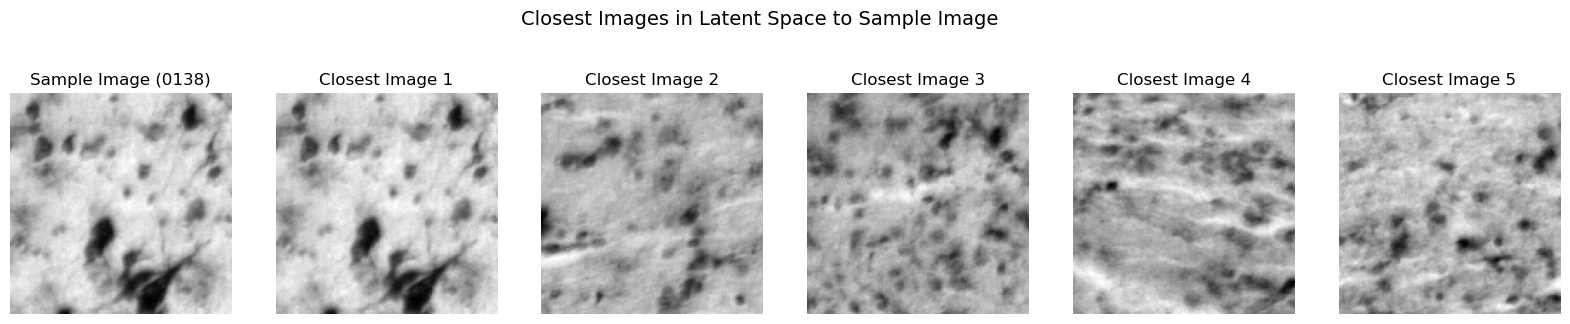

In [ ]:
# extract a sample then find the closest 5 samples to it in the latent space and visualize them
sample_idx = 33
sample_tile = sample_tiles[sample_idx].unsqueeze(0)
sample_metadata = metadata[1][sample_idx]
sample_latent, _ = model.encoder(sample_tile)
latent_distances = torch.norm(latent_representations - sample_latent, dim=1)
closest_indices = latent_distances.argsort()[:5]
closest_images = sample_tiles[closest_indices]

fig, axes = plt.subplots(1, 6, figsize=(20, 4))
axes[0].imshow(denormalize(sample_tile[0].cpu().permute(1, 2, 0).numpy(), global_mean, global_std), cmap='gray')
axes[0].set_title(f"Sample Image ({sample_metadata})")
axes[0].axis('off')

for i, ax in enumerate(axes[1:]):
    ax.imshow(denormalize(closest_images[i].cpu().permute(1, 2, 0).numpy(), global_mean, global_std), cmap='gray')
    ax.set_title(f"Closest Image {i+1}")
    ax.axis('off')

plt.suptitle("Closest Images in Latent Space to Sample Image", fontsize=14)
plt.show()

When visualized in 2D using PCA or UMAP the models failed to organize images in the latent space based on their contextual relationships (e.g., images from the same section of the brain). 

Tile Size: Using small tiles limits the model's ability, but bigger size not feasible in our case.

Random Sampler:
Struggles to capture fine-grained details and meaningful texture patterns, likely due to its inability to prioritize key features during training.
As a result, images from the same section do not cluster well in the latent space, pointing to a lack of correlation.